# XGBoost Regression - V3 Data File - Learning Curve

Do the XGBoost with the data file that includes lockdowns, holidays and retail data. Train modes on increasing sets of data and plot a learning curve (training prediction error vs validation data prediction error) to look for overfitting or underfitting.


See: https://www.dataquest.io/blog/learning-curves-machine-learning/ or https://ncheng.atlassian.net/wiki/spaces/LEARNING/pages/316833802/PY+Learning+Curves+for+Machine+Learning+Overfitting+and+Underfitting for a source on Learning curves and why they are useful

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
from utilities import graphing_utility as graph

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

# dfFootWeather = pd.read_csv("./data_files/FootTrafficWeather_July2022_Melbourne.csv")
dfFootWeather = pd.read_csv("./data_files/FootTrafficWeatherMelb2_20130101_20220701_v3.csv", parse_dates=["date"])
thisFileName = "09c.RegressionXGboostV3LearnCurve"

print(dfFootWeather.shape)
print(dfFootWeather.info())
dfFootWeather.head()

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


(3499, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3499 entries, 0 to 3498
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        3499 non-null   datetime64[ns]
 1   total_people                                3499 non-null   float64       
 2   total_rain                                  3342 non-null   float64       
 3   rain_quality                                3342 non-null   object        
 4   max_temp                                    3347 non-null   float64       
 5   max_temp_quality                            3346 non-null   object        
 6   min_temp                                    3346 non-null   float64       
 7   min_temp_quality                            3346 non-null   object        
 8   solar_exp                                   3498 non-null   float64       
 9

,date,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover
0,2022-07-31,327383.0,0.0,N,14.7,Y,4.3,Y,4.8,6,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
1,2022-07-30,462115.0,0.0,N,13.0,Y,2.1,Y,11.3,5,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
2,2022-07-29,405511.0,1.0,N,12.7,Y,6.5,Y,11.2,4,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
3,2022-07-28,334858.0,1.0,N,13.2,Y,9.3,Y,9.3,3,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
4,2022-07-27,340569.0,3.0,N,15.3,Y,9.3,Y,7.7,2,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN


# Data Load and Preparation Stage


In [2]:
dfFootWeather = dfFootWeather[dfFootWeather["total_rain"].notna()]
dfFootWeather = dfFootWeather[dfFootWeather["solar_exp"].notna()]

# assume missing quality is an N
dfFootWeather.loc[dfFootWeather["max_temp_quality"].isna(), "max_temp_quality"] = "N"

print(dfFootWeather.shape)
print(dfFootWeather.info())
dfFootWeather.head()

(3341, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3341 entries, 0 to 3346
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        3341 non-null   datetime64[ns]
 1   total_people                                3341 non-null   float64       
 2   total_rain                                  3341 non-null   float64       
 3   rain_quality                                3341 non-null   object        
 4   max_temp                                    3341 non-null   float64       
 5   max_temp_quality                            3341 non-null   object        
 6   min_temp                                    3341 non-null   float64       
 7   min_temp_quality                            3341 non-null   object        
 8   solar_exp                                   3341 non-null   float64       
 9

,date,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover
0,2022-07-31,327383.0,0.0,N,14.7,Y,4.3,Y,4.8,6,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
1,2022-07-30,462115.0,0.0,N,13.0,Y,2.1,Y,11.3,5,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
2,2022-07-29,405511.0,1.0,N,12.7,Y,6.5,Y,11.2,4,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
3,2022-07-28,334858.0,1.0,N,13.2,Y,9.3,Y,9.3,3,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
4,2022-07-27,340569.0,3.0,N,15.3,Y,9.3,Y,7.7,2,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN


### Feature Engineering

First, we need to convert any non-number columns into numbers that the model can understand. This first version isn't doing anything beyond that, later on we should probably look for any missing data flags, and maybe do some column Min/Max scaling or other.

Convert the 3 Quality Y/N columns into 1/0 values, use the shared utility function for future code reuse

In [3]:
dfFootWeather = dfutil.convertBoolColToInt(dfFootWeather, "rain_quality")
dfFootWeather = dfutil.convertBoolColToInt(dfFootWeather, "max_temp_quality")
dfFootWeather = dfutil.convertBoolColToInt(dfFootWeather, "min_temp_quality")
dfFootWeather.head()

,date,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover
0,2022-07-31,327383.0,0.0,0,14.7,1,4.3,1,4.8,6,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
1,2022-07-30,462115.0,0.0,0,13.0,1,2.1,1,11.3,5,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
2,2022-07-29,405511.0,1.0,0,12.7,1,6.5,1,11.2,4,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
3,2022-07-28,334858.0,1.0,0,13.2,1,9.3,1,9.3,3,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN
4,2022-07-27,340569.0,3.0,0,15.3,1,9.3,1,7.7,2,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN


In [4]:
print(type(dfFootWeather["date"].dtype))
print(dfFootWeather["date"].dtype == "object")
print(dfFootWeather["date"][0])
print(dfFootWeather.info())

<class 'numpy.dtype[datetime64]'>
False
2022-07-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3341 entries, 0 to 3346
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        3341 non-null   datetime64[ns]
 1   total_people                                3341 non-null   float64       
 2   total_rain                                  3341 non-null   float64       
 3   rain_quality                                3341 non-null   int64         
 4   max_temp                                    3341 non-null   float64       
 5   max_temp_quality                            3341 non-null   int64         
 6   min_temp                                    3341 non-null   float64       
 7   min_temp_quality                            3341 non-null   int64         
 8   solar_exp                   

Fill in the nulls in the holiday and lockdown columns with 0

Also, The OfflineRetail_Trend_Turnover column has nulls in the early data. In general, this value tends to be very close to the OfflineRetail_Seasonally_Adjusted_Turnover  , which has no nulls. Therefore, where Trend is null, populate it with the Seasonally Adjusted, so that null/0 values in the Trend don't skew results

In [5]:
dfFootWeather.loc[dfFootWeather["is_holiday"].isna(), "is_holiday"] = 0
dfFootWeather.loc[dfFootWeather["is_lockdown"].isna(), "is_lockdown"] = 0

dfFootWeather["OfflineRetail_Trend_Turnover"] = dfFootWeather["OfflineRetail_Trend_Turnover"].fillna(dfFootWeather["OfflineRetail_Seasonally_Adjusted_Turnover"])

print(dfFootWeather.info())
dfFootWeather.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3341 entries, 0 to 3346
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        3341 non-null   datetime64[ns]
 1   total_people                                3341 non-null   float64       
 2   total_rain                                  3341 non-null   float64       
 3   rain_quality                                3341 non-null   int64         
 4   max_temp                                    3341 non-null   float64       
 5   max_temp_quality                            3341 non-null   int64         
 6   min_temp                                    3341 non-null   float64       
 7   min_temp_quality                            3341 non-null   int64         
 8   solar_exp                                   3341 non-null   float64       
 9   WeekDay 

,date,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover
0,2022-07-31,327383.0,0.0,0,14.7,1,4.3,1,4.8,6,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3
1,2022-07-30,462115.0,0.0,0,13.0,1,2.1,1,11.3,5,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3
2,2022-07-29,405511.0,1.0,0,12.7,1,6.5,1,11.2,4,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3
3,2022-07-28,334858.0,1.0,0,13.2,1,9.3,1,9.3,3,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3
4,2022-07-27,340569.0,3.0,0,15.3,1,9.3,1,7.7,2,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3


In [6]:
dfFootWeather = dfutil.separateYmdCol(dfFootWeather, "date")
print(dfFootWeather.info())
dfFootWeather.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3341 entries, 0 to 3346
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   total_people                                3341 non-null   float64
 1   total_rain                                  3341 non-null   float64
 2   rain_quality                                3341 non-null   int64  
 3   max_temp                                    3341 non-null   float64
 4   max_temp_quality                            3341 non-null   int64  
 5   min_temp                                    3341 non-null   float64
 6   min_temp_quality                            3341 non-null   int64  
 7   solar_exp                                   3341 non-null   float64
 8   WeekDay                                     3341 non-null   int64  
 9   population_annual                           3341 non-null   int64  
 10  population_c

,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover,date_year,date_month,date_day
0,327383.0,0.0,0,14.7,1,4.3,1,4.8,6,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,31
1,462115.0,0.0,0,13.0,1,2.1,1,11.3,5,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,30
2,405511.0,1.0,0,12.7,1,6.5,1,11.2,4,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,29
3,334858.0,1.0,0,13.2,1,9.3,1,9.3,3,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,28
4,340569.0,3.0,0,15.3,1,9.3,1,7.7,2,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,27
5,316316.0,4.4,0,13.2,1,8.8,1,6.4,1,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,26
6,274106.0,0.0,0,16.8,1,8.1,1,5.1,0,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,25
7,406977.0,7.8,0,19.3,1,10.4,1,10.1,6,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,24
8,371336.0,1.2,0,14.5,1,8.1,1,5.1,5,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,23
9,416838.0,0.0,0,19.0,1,3.4,1,9.9,4,5151000,1.78,0.0,0.0,8562.7,8947.3,8947.3,2022,7,22


# Learning Curve

Here is where we will start constructing our Learning Curve. We do this by training versions of our model on different training set sizes, then get the error on predictions on the training set vs the validation set and plot them

In [7]:
train_sizes = graph.getTrainSizesForLearningCurve(dfFootWeather, 0.2, 0.2)
print(train_sizes)

[1, 534, 1069, 1603, 2138, 2672]


Run the Learning Curve function and get the errors on the training set and validation set for each train set size

In [8]:
targetColName = "total_people"
col_names = dfFootWeather.columns
feature_cols = col_names.drop([targetColName])
trainFeatures = dfFootWeather[feature_cols]
trainTargets = dfFootWeather[targetColName]

In [9]:
randomSeed = databasic.get_random_seed()

train_sizes, train_scores, validation_scores = learning_curve(    
    estimator = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
        n_estimators=200, max_depth=6, colsample_bytree=0.7, eta=0.1,
        seed=randomSeed)
    ,X = trainFeatures
    ,y = trainTargets
    ,train_sizes=train_sizes
    ,cv = 5
    ,scoring = "neg_mean_absolute_error"    
    #,shuffle = True
)
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-4.85937500e+00 -1.14375000e+01 -1.14375000e+01 -1.14375000e+01
  -1.14375000e+01]
 [-3.02896917e+03 -2.43312498e+03 -2.43312498e+03 -2.43312498e+03
  -2.43312498e+03]
 [-7.99601281e+03 -5.43695803e+03 -6.67149022e+03 -6.67149022e+03
  -6.67149022e+03]
 [-9.17523593e+03 -7.96566440e+03 -9.57417795e+03 -1.01708182e+04
  -1.01708182e+04]
 [-1.14796550e+04 -1.05583938e+04 -1.13692978e+04 -1.19592746e+04
  -1.20423999e+04]
 [-1.24740071e+04 -1.16116566e+04 -1.27203079e+04 -1.33841537e+04
  -1.34597129e+04]]

 ----------------------------------------------------------------------

Validation scores:

 [[-176170.70134996 -329517.77975299 -296119.42122006 -270028.93488024
   -91597.68731287]
 [-164013.68606362 -460848.56817225 -510658.07055225 -486745.72339891
  -272287.93127222]
 [-164535.23602158 -380104.31583903  -87096.72950973  -64815.18188623
  -246197.12687126]
 [-173097.82345969 -379387.64144952  -56950.27792852 -137071.74078406
  -349965.07756362]
 [-170304.31708

Get the Mean Training Scores and Validation Scores for each train size

In [10]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1          10.121875
534      2552.293817
1069     6689.488301
1603     9411.342952
2138    11481.804215
2672    12729.967657
dtype: float64

 --------------------

Mean validation scores

 1       232686.904903
534     378910.795892
1069    188549.718026
1603    219294.512237
2138    172604.071498
2672    170147.465949
dtype: float64


In [11]:
scores_diff = validation_scores_mean - train_scores_mean

min_error_diff = min(list(filter(lambda x: x > 0, scores_diff)))
print(scores_diff)
print("Min Gap (Difference in error between Training and Validation): " + str(min_error_diff))

[232676.78302823 376358.50207455 181860.22972486 209883.16928536
 161122.26728358 157417.498292  ]
Min Gap (Difference in error between Training and Validation): 157417.4982919996


Min Gap Results:


Plot the Learning Curve

In [12]:
print(train_sizes)
print(train_scores_mean)
print(validation_scores_mean)

[   1  534 1069 1603 2138 2672]
[1.01218750e+01 2.55229382e+03 6.68948830e+03 9.41134295e+03
 1.14818042e+04 1.27299677e+04]
[232686.90490323 378910.79589185 188549.71802556 219294.51223708
 172604.07149821 170147.46594862]


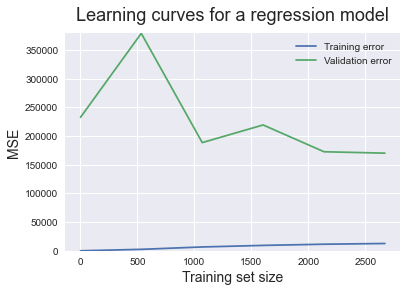

In [13]:
# # Hard code 0 for 1 cos that's what it theoretically should be, just to show the right graph
# train_scores_mean[0] = 0

plt = graph.graphLearningCurve(train_sizes, train_scores_mean, validation_scores_mean)
plt.show()

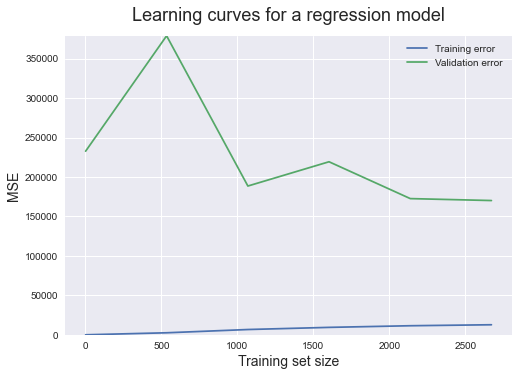

In [14]:
maxY = validation_scores_mean.max()
if train_scores_mean.max() > maxY:
    maxY = train_scores_mean.max() # This shouldn't happen 

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,maxY)

plt.show()